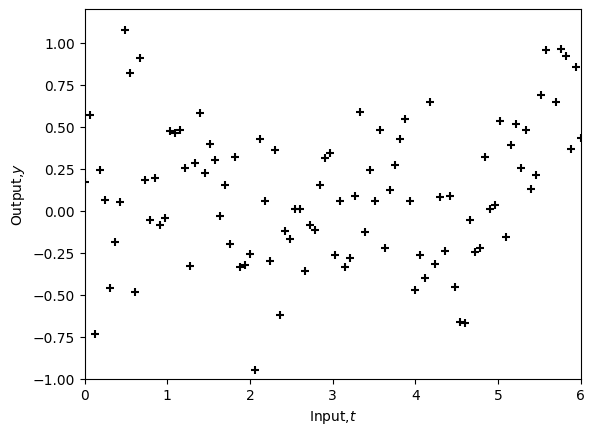

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from scipy.io import loadmat
import scipy

x = loadmat('x.mat')
y = loadmat('y.mat')

x = x['x'].reshape(-1)
y = y['y'].reshape(-1)

plt.scatter(x,y,marker='+', color = 'k')
plt.xlim([0,6])
plt.ylim([-1,1.2])
plt.xlabel('Input,$t$')
plt.ylabel('Output,$y$')
plt.show()

## Full GP solution with parameter optimization

In [4]:
from scipy.optimize import minimize

def matern32_kernel(X, Y, lengthscale=1.0, variance=1.0):
    distance = np.abs(X - Y.T)
    sqrt3 = np.sqrt(3.0)
    K = variance * (1.0 + sqrt3 * distance / lengthscale) * np.exp(-sqrt3 * distance / lengthscale)
    return K

def dk1(r, p):
    return (1 + np.sqrt(3) * np.abs(r)/p[1]) * np.exp(-np.sqrt(3)*np.abs(r)/p[1])

def dk2(r, p):
    return p[0]*(3 * r**2/p[1]**3) * np.exp(-np.sqrt(3)*np.abs(r)/p[1])

def gp_solve(params, x, y,  xt = None, opt = True):
    '''
    Args:
    params  - Log-Parameter (sigma2, magnSigma2, lengthscale)
    x       - Training inputs
    y       - Training outputs
    opt     - True if optimizing params; False if inferring
    
    Returns:
    (if xt is empty or not supplied)
    e       - Negative log-marginal likelihood
    eg      - its gradient

    (if xt is not empty)
    Eft     - Predicted mean
    Varft   - Predicted marginal variance
    Covft   - Predicted joint covariance matrix
    lb      - 95% confidence lower bound
    ub      - 95% confidence upper bound
    '''

    param = np.exp(params)
    sigma2 = param[0]
    magnSigma2 = param[1]
    lengthscale = param[2]

    K11 = matern32_kernel(x.reshape(-1,1), x.reshape(-1,1), lengthscale, magnSigma2) + np.eye(x.shape[0]) * sigma2

    try:
        L = np.linalg.cholesky(K11)
    except np.linalg.LinAlgError:
        jitter = 1e-9 * np.eye(x.shape[0])
        L = np.linalg.cholesky(K11 + jitter)


    x = x.reshape(-1,1)
    y = y.reshape(-1,1)

    vv = np.linalg.solve(L, y)
    alpha = np.linalg.solve(L.T, vv)

    if xt == None:
        xt = x

    if not opt:
        K21 = matern32_kernel(xt, x, lengthscale, magnSigma2)
        K22 = matern32_kernel(xt, xt, lengthscale, magnSigma2)
        
        # Solve for Mean
        Eft = K21 @ alpha
        
        # Solve for variance
        v = np.linalg.solve(L, K21.T)
        #vk = np.linalg.solve(L.T, v)
        #cov = K22 - K21 @ vk
        cov = K22 - v.T @ v

        # Marginal
        var = np.diag(cov)
        lb = Eft.ravel() -  1.96 * np.sqrt(var)
        ub = Eft.ravel() + 1.96 * np.sqrt(var)

        return Eft, var, cov, lb, ub
    
    else:
        # Evaluate negative log marginal likelihood
        beta1 = vv.T @ vv
        e = 0.5 * beta1 + np.sum(np.log(np.diag(L))) + 0.5*x.shape[0]*np.log(2*np.pi)

        # calculate gradient of log marginal likelihood
        eg = np.zeros(len(param))

        # Derivate w.r.t sigma2 i.e. noise variance
        invk = np.linalg.solve(L.T, np.linalg.solve(L, np.eye(x.shape[0])))
        eg[0] = 0.5 * np.trace(invk) - 0.5 * (alpha.T @ alpha)[0][0]

        # Derivative w.r.t. rest of the parameters
        for i in range(1, len(param)-1):
            r = x[:, None] - x[None,:]
            dK = dk1(r, param[1:]) if i == 1 else dk2(r, param[1:])
            dK = dK.reshape(dK.shape[0],dK.shape[1])
            eg[i] = 0.5 * np.sum(invk * dK) - 0.5 * (alpha.T @ (dK @ alpha))[0][0]
            
        # during optimization if jac = True, you need to return the gradient as well; if jac = False, gradient will be approximated numerically
        return e.item() #, eg
    



param = np.array([0.1, 0.1, 0.1])

def objective_function(w):
    return gp_solve(w,x,y,xt = None, opt = True)

result = minimize(fun = objective_function, x0 = np.log(param), method = 'BFGS', jac = False, options={'disp': True})  # Nelder-Mead, Powell, BFGS, CG, Newton-CG

w1 = result.x
ll1 = result.fun

Eft1, var1, _, lb1, ub1 = gp_solve(params = w1, x = x, y = y, xt = None, opt = False)

plt.figure()
plt.scatter(x,y,marker='+', color = 'k')
plt.plot(x, Eft1, label = 'Full GP Mean', color = 'r', linestyle = '--', linewidth = 0.9)
plt.plot(x, lb1, color = 'r', linestyle = '--', linewidth = 0.8)
plt.plot(x, ub1, color = 'r', linestyle = '--', linewidth = 0.8)
plt.fill_between(x.flatten(), lb1, ub1, color = 'gray', label = '95% Quantile', alpha = 0.5)


plt.xlim([0,6])
plt.ylim([-1,1.2])
plt.xlabel('Input,$t$')
plt.ylabel('Output,$y$')
plt.legend()
plt.show()

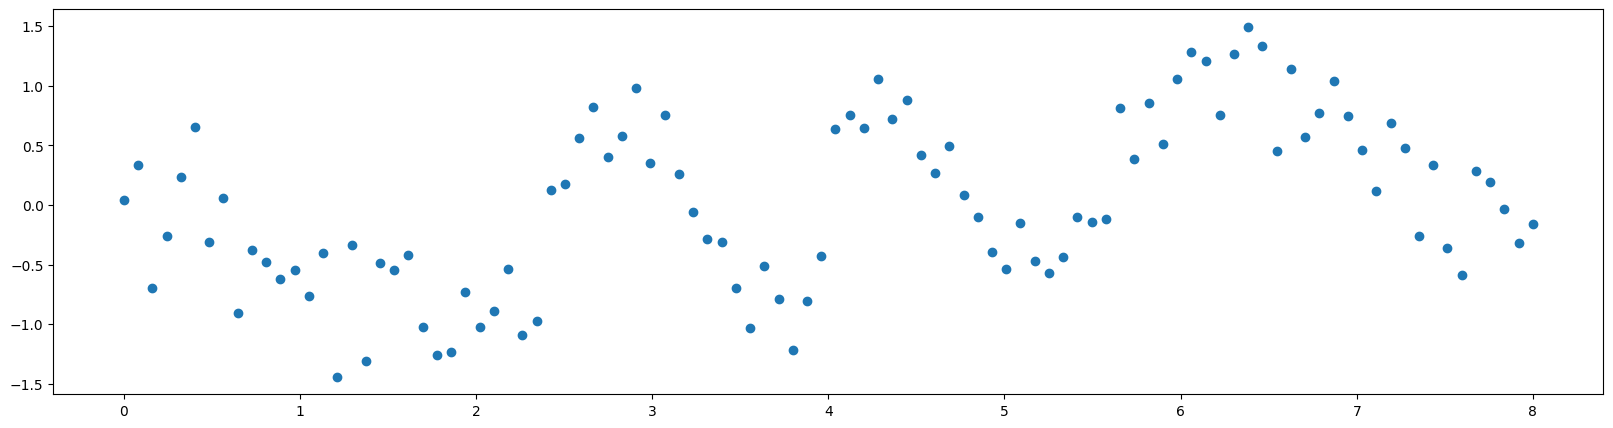

In [2]:
np.random.seed(53)
x = np.linspace(0, 8, 100) 
y = -np.exp(-(x-4)**2 * 0.5) * (4*(x-4)**2 - 2) * np.cos(x-4) * np.cbrt(x-4) + np.sqrt(0.1) * np.random.randn(100)

plt.figure(figsize=(20,5))
plt.scatter(x,y)


x_train = x[0:50]
y_train = y[0:50]
x_test = x[50:]
y_test = y[50:]

Optimization terminated successfully.
         Current function value: 99.589780
         Iterations: 4
         Function evaluations: 125

 optimized hyperparams = [0.09963855 0.46191823 0.4976901 ]


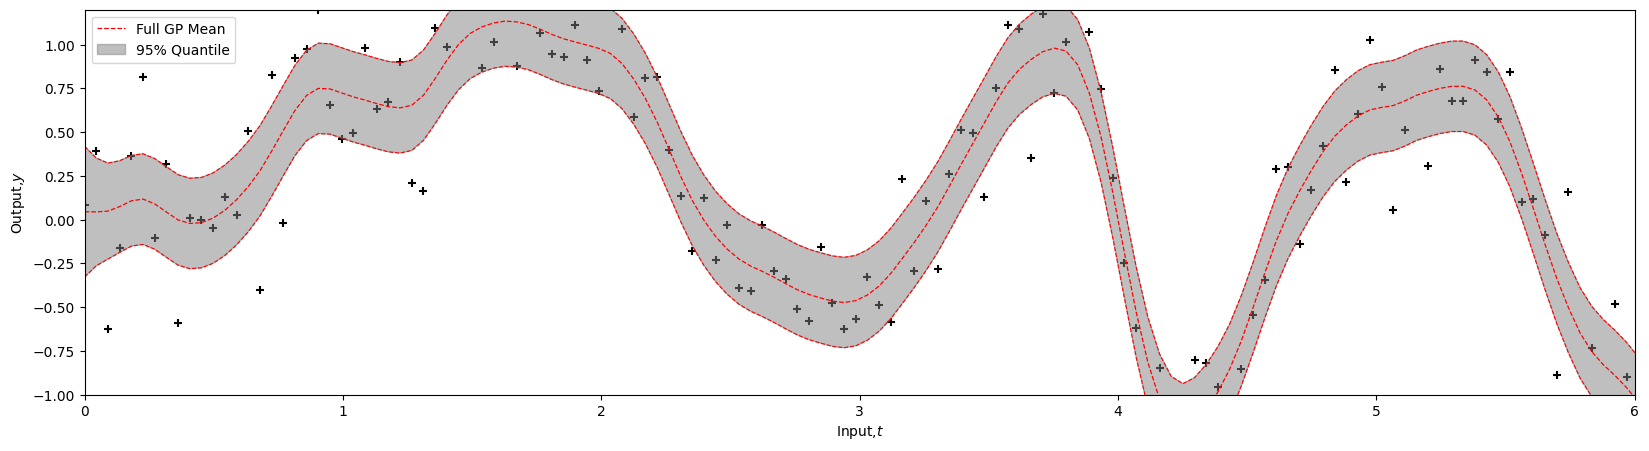

In [3]:
from methods import Vanilla_GP

param = np.array([0.1,0.1,0.1])
gp_model = Vanilla_GP(params = param)
gp_model.optimize(x,y)
Eft1, var1, _, lb1, ub1 = gp_model.gp_solve(x,y,opt = False)
print (f'\n optimized hyperparams = {gp_model.get_params()}')

plt.figure(figsize=(20,5))
plt.scatter(x,y,marker='+', color = 'k')
plt.plot(x, Eft1, label = 'Full GP Mean', color = 'r', linestyle = '--', linewidth = 0.9)
plt.plot(x, lb1, color = 'r', linestyle = '--', linewidth = 0.8)
plt.plot(x, ub1, color = 'r', linestyle = '--', linewidth = 0.8)
plt.fill_between(x.flatten(), lb1, ub1, color = 'gray', label = '95% Quantile', alpha = 0.5)


plt.xlim([0,6])
plt.ylim([-1,1.2])
plt.xlabel('Input,$t$')
plt.ylabel('Output,$y$')
plt.legend()
plt.show()

## IHGP Implementation

In [5]:
from scipy.optimize import minimize

def cf_matern_to_ss(magnSigma2, lengthscale, opt = False):
    # Form State Space Model
    Lambda = np.sqrt(3)/lengthscale
    F = np.array([[0, 1],[-Lambda**2, -2*Lambda]])
    L = np.array([0,1]).reshape(2,1)
    Qc = 12 * (np.sqrt(3)/lengthscale**3) * magnSigma2
    H = np.array([1, 0]).reshape(1,2)
    Pinf = magnSigma2 * np.diag([1, 3/lengthscale**2])


    if opt == True:
        # Calculate Derivatives
        dFmagnSigma2 = np.zeros(shape = (F.shape[0], F.shape[1]))
        dFlengthscale = np.array([[0, 0],[6/lengthscale**3, 2*np.sqrt(3)/lengthscale**2]])
        
        dQcmagnSigma2 = 12 * np.sqrt(3)/lengthscale**3
        dQclengthscale = -3 * 12 * np.sqrt(3)/lengthscale**4 * magnSigma2

        dPinfmagnSigma2 = np.array([[1, 0], [0, 3 / lengthscale**2]])
        dPinflengthscale = magnSigma2 * np.array([[0, 0], [0, -6 / lengthscale**3]])

        # stack all derivates
        dF = np.zeros((2, 2, 2))
        dQc = np.zeros((1, 1, 2))
        dPinf = np.zeros((2, 2, 2))

        dF[:,:,0] = dFmagnSigma2
        dF[:,:,1] = dFlengthscale

        dQc[0,0,0] = dQcmagnSigma2
        dQc[0,0,1] = dQclengthscale

        dPinf[:,:,0] = dPinfmagnSigma2
        dPinf[:,:,1] = dPinflengthscale


        return F, L, Qc, H, Pinf, dF, dQc, dPinf
    
    else:
        return F, L, Qc, H, Pinf


ss = lambda x, p, f: cf_matern_to_ss(p[0], p[1], f)


def ihgpr(w, x, y, ss, xt = None, opt = False):
    '''
    Adapted from IHGP Paper: A. Solin et.al. (2018)

    Args:
    w       - Log-Parameters [sigma^2, magSigma^2, lengthscale]
    x       - Training Inputs
    y       - Training Outputs
    ss      - Function to get State-Spac Represention of Stationary Covariance Function
    xt      - Testing Points (default = None)
    opt     - To Optimize Hyperparameters or Not (Boolean)

    Returns:
    (If opt is False)
    Eft     - Predicted Mean
    var     - Predicted Variance (Marginal)
    cov     - Predicted Covariance (Joint)
    lb      - Lower Bound for Eft (95 %)
    ub      - Upper Bound for Eft (95 %)

    (If opt is True)
    edata   - Negative Log-Marginal Likelihood
    gdata   - Its Gradient
    '''

    # Combine observations and test points
    
    if xt == None:
        xt = x

    xall = np.concatenate([x.flatten(), xt.flatten()])
    yall = np.concatenate([y.flatten(), np.nan * np.ones(len(xt))])

    # Make sure points are unique and are in ascending order
    xall, sort_ind = np.unique(xall, return_index = True)
    yall = yall[sort_ind]

    # Only return test indices
    return_ind = np.arange(len(xall)) + 1
    return_ind = return_ind[-len(xt):]

    if np.std(np.diff(xall)) > 1e-12:
        raise Exception('This function only accepts equidistant time-stamps only')
    
    param = np.exp(w)
    
    d = len(x)
    sigma2 = param[0]

    # Form State-Space Model
    F, L, Qc, H, Pinf, dF_, dQc_, dPinf_ = ss(x, param[1:], f=True)

    # Concatenate Derivatives
    dF = np.zeros((F.shape[0], F.shape[1], len(param)))
    dPinf = np.zeros((F.shape[0], F.shape[1], len(param)))
    dQc = np.zeros((1,1,len(param)))

    dF[:,:,1:] = dF_
    dQc[:,:,1:] = dQc_
    dPinf[:,:,1:] = dPinf_
    dR = np.zeros((1,1,len(param)))
    dR[:,:,0] = 1
    

    # Stationary Stuffs
    dt = xall[1] - xall[0]
    A = scipy.linalg.expm(F * dt)
    Q = Pinf - A @ Pinf @ np.transpose(A)
    Q = (Q + Q.T)/2
    R = sigma2

    try:
        Pp = scipy.linalg.solve_discrete_are(A.T, H.T, Q, R)
    except Exception as e:
        print (f'Unstable DARE Solution: {e}')


    # Innovation variance
    S = H @ Pp @ H.T + R

    # Stationary Gain
    K = Pp @ H.T / S.item()

    # Pre-calculate
    AKHA = A - K @ H @ A


    if not opt:
        # -----Filtering and Smoothing -----

        # set initial state
        m = np.zeros((F.shape[0], 1))
        PF = Pp - K @ H @ Pp

        # Allocate space for results
        MS = np.zeros((F.shape[0], len(yall)))
        PS = np.zeros((F.shape[0], F.shape[1], len(yall)))

        # Filter Forward Recursion
        for k in range(len(yall)):
            if ~np.isnan(yall[k]):
                m = AKHA @ m + K * yall[k]             # O(m^2) Complexity

                # Store Estimate
                MS[:, k] = m.T                   
                PS[:,:,k] = PF                         # Same for all points
            else:
                m = A @ m
                MS[:, k] = m.T
                PS[:,:,k] = Pinf
        
        # Backward Smoother
        GS = np.zeros([2, 2, len(yall)])               # Allocate space for Smoother Gain
        Lo = np.linalg.cholesky(Pp)

        #G = PF @ A.T @ np.linalg.inv(Lo.T) @ np.linalg.inv(Lo)
        G = (np.linalg.solve((Lo @ Lo.T), A @ PF.T)).T


        # Solve Riccati Equation
        QQ = PF - G @ Pp @ G.T
        QQ = (QQ + QQ.T)/2
        P = scipy.linalg.solve_discrete_are(G.T, np.zeros_like(G), QQ, Q)      # Q -- >  np.eye(F.shape[0])
        PS[:,:,-1] = P


        # RTS Smoothing
        m = m.T.reshape(2)
        for k in range(MS.shape[1] - 2, -1, -1):  # MS.shape[1] gives the number of columns in MS
            # Backward iteration
            m = MS[:, k] + G @ (m - A @ MS[:, k])
            # Store estimate
            MS[:, k] = m
            PS[:, :, k] = P
            GS[:, :, k] = G
        
        # Return smoother mean and marginal variance
        Eft = (H @ MS).T
        Varft = []
        for i in range(len(MS[1])):
            Varft.append( H @ PS[:, :, i] @ H.T)

        lb = Eft.reshape(-1) - 1.96 * np.sqrt(np.array(Varft).reshape(-1))
        ub = Eft.reshape(-1) + 1.96 * np.sqrt(np.array(Varft).reshape(-1))

        return Eft.reshape(-1), np.array(Varft).reshape(-1), lb, ub
    
    else:
        # -----Optimize Hyperparameters-----
        d = np.size(F, 1)
        nparam = len(param)

        # Allocate space for derivatives
        dA = np.zeros((d, d, nparam))
        dPP = np.zeros((d, d, nparam))
        dAKHA = np.zeros((d, d, nparam))
        dK = np.zeros((d, 1, nparam))
        dS = np.zeros((1, 1, nparam))
        HdA = np.zeros((d, nparam))

        
        # Pre-calculate Z and B
        Z = np.zeros((d,d))
        B = A @ K


        # Evaluate all derivatives
        for j in range(len(param)):
            # First matrix for the matrix factor decomposition
            FF_top = np.hstack([F, Z])
            FF_bottom = np.hstack([dF[:,:,j], F])
            FF = np.vstack([FF_top, FF_bottom])  
  
            
            # Solve matrix exponential
            AA = scipy.linalg.expm(FF * dt)
            dA[:,:,j] = AA[d:, :d]
            dQ = dPinf[:,:,j] - dA[:,:,j] @ Pinf @ A.T - A @ dPinf[:,:,j] @ A.T - A @ Pinf @ dA[:, :, j].T
            dQ = (dQ + dQ.T)/2

            # Precalculate C
            C = dA[:,:,j] @ Pp @ A.T + A @ Pp @ dA[:,:,j].T - dA[:,:,j] @ Pp @ H.T @ B.T - B @ H @ Pp @ dA[:, :, j].T + B @ dR[:,:,j] @ B.T + dQ
            C = (C + C.T)/2

            try:
                dPP[:,:,j] = scipy.linalg.solve_discrete_are((A - B @ H).T, np.zeros((d,d)), C, np.eye(d))
            except Exception as e:
                print (f'Unstable DARE Solution while evaluating derivatives: {e}')
            
            # Evaluate dS and dK
            dS[:,:,j] = (H @ dPP[:,:,j] @ H.T).item() + dR[:,:,j]
            dK[:,:,j] = dPP[:,:,j] @ H.T / S.item() - Pp @ H.T * (((H @ dPP[:,:,j] @ H.T).item() + dR[:,:,j])/S.item()**2)
            dAKHA[:,:,j] = dA[:,:,j] - dK[:,:,j] @ H @ A - K @ H @ dA[:,:,j]
            HdA[:,j] = (H @ dA[:,:,j]).reshape(-1).T     # (2,1) -- > (2,) 

        # Reshape for vectorization
        dAKHAp = dAKHA.transpose(2,0,1).reshape(-1,2)
        dKp = dK.reshape(2,-1)

    
        # Size of inputs
        steps = len(yall)
        m = np.zeros((d,1))
        dm = np.zeros((d, nparam))

        # Allocate space for results
        edata = 0.5 * np.log(2*np.pi)*steps + 0.5 * np.log(S.item())*len(x)
        gdata = 0.5 * steps * dS.ravel().reshape(-1, nparam) / S.item()


        # Loop over all observations
        for k in range(steps):

            if ~np.isnan(y[k]):

                # Innovation Mean
                v = y[k] - (H @ A @ m).item()

                # Marginal Likelihood Approximation
                edata += 0.5 * v**2/S.item()

                # Same as above without the loop
                dv  = -m.T @ HdA - H @ A @ dm
                gdata += v * dv/S.item() - 0.5 * v**2 * dS.ravel().reshape(-1, nparam) / S.item()**2
                dm = AKHA @ dm + dKp * y[k]   # (2,3)
                dm = dm.reshape(-1,1)         # (6,1)
                dm += dAKHAp @ m              # (6,1)
                dm = dm.reshape(d, -1)        # (2,3)

                # Stationary Filter Recursion
                m = AKHA @ m + K * y[k]

            else:
                for j in range(len(param)):
                    dm[:,j] = (A @ dm[:,j].reshape(d,1) + dA[:,:,j] @ m).reshape(-1)
                m = A @ m
        

        # Account for log-scale
        gdata = gdata * np.exp(w)

        return edata #, gdata.reshape(3)
    
#######################################   

param = np.array([0.1, 0.1, 0.1])
ss = lambda x, p, f: cf_matern_to_ss(p[0], p[1], f)

def objective_function(w):
    return ihgpr(w,x,y,ss,xt = None, opt = True)

result = minimize(fun = objective_function, x0 = np.log(param), method = 'BFGS', jac = False, options={'disp': True})  # Nelder-Mead, Powell, BFGS, CG, Newton-CG

w2 = result.x       # Need close to = [-2.0576, -2.2237, -0.2113]
ll2 = result.fun

print ('Weights: ', np.exp(w2))
print ('-ve Log Likelihood: ', ll2)
Eft2, var2, lb2, ub2 = ihgpr(w = w2, x = x, ss = ss, y = y, xt = None, opt = False)

Optimization terminated successfully.
         Current function value: 98.805934
         Iterations: 4
         Function evaluations: 125

 optimized hyperparams = [0.09927104 0.49586256 0.51583313]


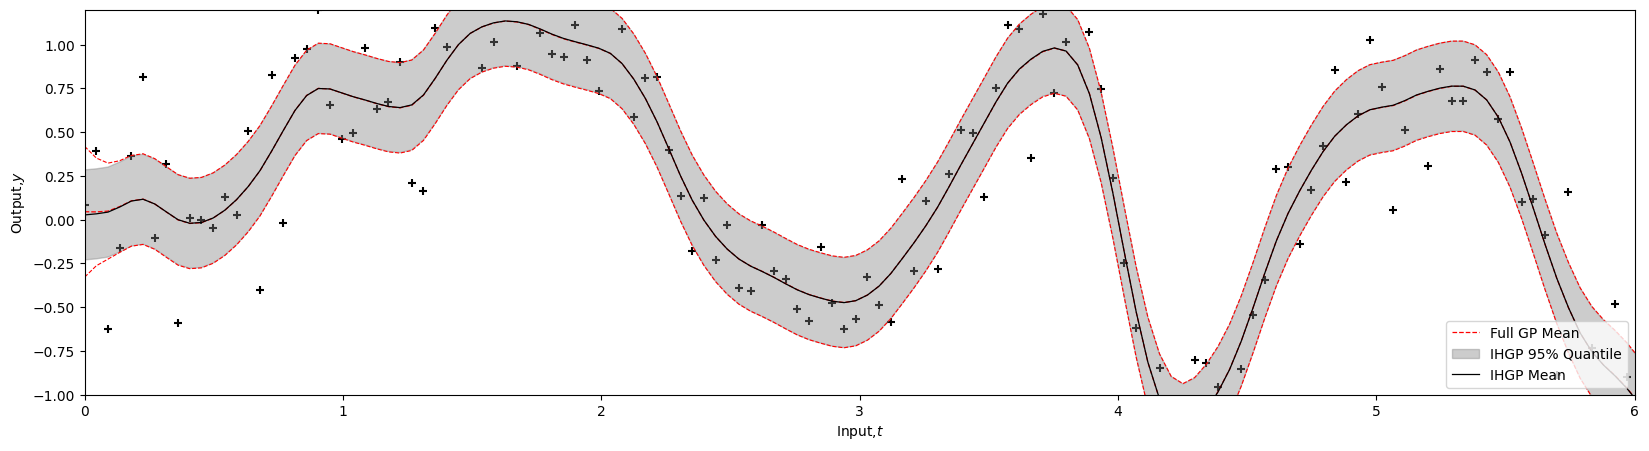

In [4]:
from scipy.optimize import minimize
from methods import IHGP

param = np.array([0.1,0.1,0.1])
ihgp_model = IHGP(params = param)
ihgp_model.optimize(x,y, xt = None)

Eft2, var2, lb2, ub2 = ihgp_model.ihgpr(x,y,opt = False)
print (f'\n optimized hyperparams = {ihgp_model.get_params()}')

plt.figure(figsize=(20,5))
plt.scatter(x,y,marker='+', color = 'k')
plt.plot(x, Eft1, label = 'Full GP Mean', color = 'r', linestyle = '--', linewidth = 0.9)
plt.plot(x, lb1, color = 'r', linestyle = '--', linewidth = 0.8)
plt.plot(x, ub1, color = 'r', linestyle = '--', linewidth = 0.8)
plt.fill_between(x.flatten(), lb2, ub2, color = 'gray', label = 'IHGP 95% Quantile', alpha = 0.4)

plt.plot(x, Eft2, label = 'IHGP Mean', color = 'k', linestyle = '-', linewidth = 0.9)

plt.xlim([0,6])
plt.ylim([-1,1.2])
plt.xlabel('Input,$t$')
plt.ylabel('Output,$y$')
plt.legend(loc='lower right')
plt.show()

## MCMC

In [1]:
from methods import MarkovChainMC
import torch, pyro
import numpy as np
from scipy.io import loadmat

x = loadmat('x.mat')
y = loadmat('y.mat')

x = x['x'].reshape(-1)
y = y['y'].reshape(-1)

# Set seed for reproducibility
torch.manual_seed(2024)
pyro.set_rng_seed(2024)

# run MCMC
mcmc = MarkovChainMC(x, y, num_samples = 1000, num_warmups = 500)
samples = mcmc.run_inference()

Sample: 100%|██████████| 1500/1500 [01:05, 22.83it/s, step size=4.81e-01, acc. prob=0.859]


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
  Kernel_amplitude      0.07      0.03      0.06      0.02      0.12    814.02      1.00
     Kernel_length      8.77      3.81      7.57      4.82     13.50    266.12      1.00
      Kernel_noise      0.00      0.00      0.00      0.00      0.00    658.91      1.00

Number of divergences: 4



 optimized hyperparams = [0.1274554  0.12801094 0.74805313]


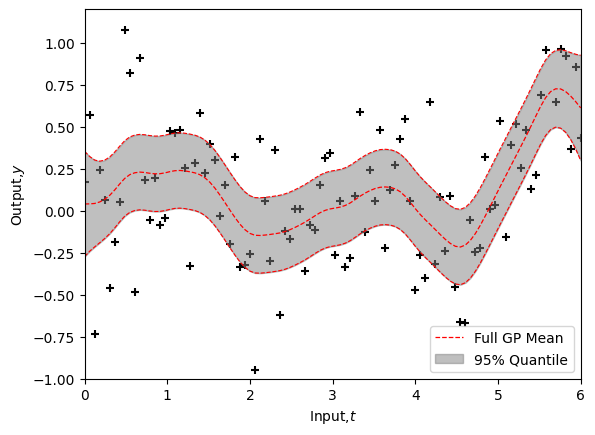

In [9]:
from methods import Vanilla_GP


from methods import MarkovChainMC
import torch
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt

x = loadmat('x.mat')
y = loadmat('y.mat')

x = x['x'].reshape(-1)
y = y['y'].reshape(-1)

param = np.array([-2.059988791737631,-2.055639522373452,-0.2902812694559931])   # log scales
gp_model = Vanilla_GP(params = param)
#gp_model.optimize(x,y)
Eft1, var1, _, lb1, ub1 = gp_model.gp_solve(x,y,opt = False)
print (f'\n optimized hyperparams = {gp_model.get_params()}')

#plt.figure(figsize=(20,5))
plt.scatter(x,y,marker='+', color = 'k')
plt.plot(x, Eft1, label = 'Full GP Mean', color = 'r', linestyle = '--', linewidth = 0.9)
plt.plot(x, lb1, color = 'r', linestyle = '--', linewidth = 0.8)
plt.plot(x, ub1, color = 'r', linestyle = '--', linewidth = 0.8)
plt.fill_between(x.flatten(), lb1, ub1, color = 'gray', label = '95% Quantile', alpha = 0.5)


plt.xlim([0,6])
plt.ylim([-1,1.2])
plt.xlabel('Input,$t$')
plt.ylabel('Output,$y$')
plt.legend()
plt.show()

## MAP Estimate

In [21]:
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt

x = loadmat('x.mat')
y = loadmat('y.mat')

x = x['x'].reshape(-1)
y = y['y'].reshape(-1)

In [60]:
import torch, pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

torch.manual_seed(2024)
pyro.set_rng_seed(2024)

pyro.clear_param_store()
kernel = gp.kernels.Matern32(input_dim = 1, variance = torch.tensor(0.1), lengthscale = torch.tensor(0.1))

gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise = torch.tensor(0.1))

# priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

optimizer = torch.optim.Adam(gpr.parameters(), lr = 0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

num_steps = 2000

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()

# sample from this guide
gpr.set_mode('guide')
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("noise = {}".format(gpr.noise))

variance = 0.13159677386283875
lengthscale = 0.764681875705719
noise = 0.12751640379428864


## Plot

In [2]:
import os 
import pandas as pd
import numpy as np
import torch, pyro
from methods import *
import matplotlib.pyplot as plt

import time


# Set seed for reproducibility
torch.manual_seed(2024)
pyro.set_rng_seed(2024)
np.random.seed(2024)

# Supply params without log-transformaion
# Note: Fix noise_var parameter for this case to be N(0, 0.1) to get a contour plot

# Create a meshgrid of parameters
amplitude_var = np.linspace(1e-3, 10**2, 2)
lengthscale = np.linspace(1e-3, 10**2, 2)
sigma_sq, length = np.meshgrid(amplitude_var, lengthscale)

# Initialize dictionary to store results
results = {}


# Retrieve list of CSV files
csv_files = [file for file in os.listdir('Datasets') if file.endswith('.csv')]

# Start time
start = time.time()

for file in csv_files:
    print (f'\n----Reading: {file}----\n')

    df = pd.read_csv(os.path.join('Datasets', file))
    
    if file != '2023-States.csv':
        x = np.array(df[df.columns[0]]).astype(float)
        y = np.array(df[df.columns[1]]).astype(float)
    else:
        df_filter = df[df['Entity'] == 'Moldova']
        y = np.array(df_filter['Flights']).astype(float)
        x = np.arange(0, len(y)).astype(float)

    # Standardize data
    x = (x - min(x))/(max(x) - min(x))
    y = (x - min(y))/(max(y) - min(y))

    if file == 'Sunspot_Num_Yearly_Mean.csv':
        window_size = 54
    elif file == 'synthetic_data.csv':
        window_size = 40
    else:
        window_size = 73

    j = window_size
    window_range = int(len(y)/window_size)

    # Initialize an empty dictionary for this file
    results[file] = {}

    for i in range(window_range):
        print (f'Evaluating Window: {i+1}/{window_range}...\r')
        x_chunk = x[j-window_size:j]
        y_chunk = y[j-window_size:j]
        j += window_size


        # Store function values
        func_val_GP = np.zeros_like(sigma_sq)
        func_val_IHGP = np.zeros_like(sigma_sq)
        func_val_MAP = np.zeros_like(sigma_sq)


        for k in range(sigma_sq.shape[0]):
            for l in range(length.shape[0]):
                func_val_GP[k,l] = Vanilla_GP(params = [0.1, amplitude_var[k], lengthscale[l]]).gp_solve(x_chunk, y_chunk, 
                                                                                                xt = None, opt = True, get_likelihood = True)
                func_val_IHGP[k,l] = IHGP(params = [0.1, amplitude_var[k], lengthscale[l]]).ihgpr(x_chunk, y_chunk, 
                                                                                        xt = None, opt = True, get_likelihood = True)
                func_val_MAP[k,l] = MaximumAposteriori(x_chunk, y_chunk, init_params = [0.1, amplitude_var[k], lengthscale[l]], 
                                                        num_steps = 2000, learning_rate = 0.005).map_objective()
            
        
        # Store these values
        results[file][i] = {'GP': func_val_GP, 'IHGP': func_val_IHGP, 'MAP': func_val_MAP}

print ('\n=======Completed=======\n')
print ('Total Time Taken {:.3f} seconds'.format(time.time()-start))




----Reading: Sunspot_Num_Yearly_Mean.csv----

Evaluating Window: 1/6...
Evaluating Window: 2/6...
Evaluating Window: 3/6...
Evaluating Window: 4/6...
Evaluating Window: 5/6...
Evaluating Window: 6/6...

----Reading: synthetic_data.csv----

Evaluating Window: 1/5...
Evaluating Window: 2/5...
Evaluating Window: 3/5...
Evaluating Window: 4/5...
Evaluating Window: 5/5...

----Reading: 2023-States.csv----

Evaluating Window: 1/5...
Evaluating Window: 2/5...
Evaluating Window: 3/5...
Evaluating Window: 4/5...
Evaluating Window: 5/5...

=======Completed=======

Total Time Taken 7.838 seconds


In [26]:
import pickle

with open('save_dict.pkl', 'wb') as f:
    pickle.dump(results,f)



In [30]:
with open('save_dict.pkl', 'rb') as f:
    loaded = pickle.load(f)

loaded.keys()

dict_keys(['Sunspot_Num_Yearly_Mean.csv', 'synthetic_data.csv', '2023-States.csv'])